<a href="https://colab.research.google.com/github/deepakri201/nlst_explore/blob/main/Exploratory_analysis_NLST_126k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explores the 126k series NLST results.

In [44]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [45]:
import os
import sys
import time
import json
import subprocess
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sb
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

from collections import OrderedDict

import seaborn as sns

from pathlib import Path

import random

import collections

In [46]:
!pip install bokeh==2.4.3

In [47]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

In [48]:
import bokeh
bokeh.__version__

'2.4.3'

# Parameterization

In [49]:
# table_id = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status
table_id_126k = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"
table_id_10k = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status

# Functions

In [50]:
def color_list_generator(df, col):
  """

  Create a list of colors per col given a dataframe

  Arguments:
    df    : dataframe to get data from
    col   : column to use to get unique treatments.

  Returns:
    colormap   : the colormap created
    colors     : the actual colors

  Inspired by creating colors for each treatment
  Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
  Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html

  """

  if (len(df[col].unique()))==1:
    colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
  elif (len(df[col].unique()))==2:
    colors = brewer["Dark2"][3][0:2]
  elif (len(df[col].unique()))>8:
    num_colors = len(df[col].unique())
    num_colormaps = np.int32(np.ceil(num_colors/8))
    colormap_chained = brewer["Dark2"][8]*num_colormaps
    colors = colormap_chained[0:num_colors]
  else:
    colors = brewer["Dark2"][len(df[col].unique())]

  # Create a map between treatment and color.
  colormap = {i: colors[k] for k,i in enumerate(df[col].unique())}

  # sort these according to the key
  colormap = collections.OrderedDict(sorted(colormap.items()))

  # Return a list of colors for each value that we will be looking at.
  return colormap, [colormap[x] for x in df[col]]

# NLST segmentation verification

## Verify the consistency between the left and right organs

kidney, adrenal gland, humerus, scapula, clavicle, femur, hip, autochthon, iliopsoas gluteus maximus, gluteus medius, gluteus minimus

## Bland-Altman bokeh plot between left and right number of axial slices

Bland-Altman bokeh plot between left and right number of axial slices

In [ ]:
client = bigquery.Client(project=project_name)

query = f"""

  SELECT
     DISTINCT(SOPInstanceUID),
     StudyInstanceUID,
     age,
     gender,
     Value,
     nlst_ctab.sct_ab_desc
  FROM
    `idc-external-025.terra.nlst-126k-measurements-clinical-acquisition` as clinical_table
  JOIN
    `bigquery-public-data.idc_v15_clinical.nlst_ctab` as nlst_ctab
  ON
    clinical_table.PatientID = nlst_ctab.pid
  WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature;

  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("region", "STRING", region),
                                                      bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                      ])
df = client.query(query, job_config=job_config).to_dataframe()


## Correlation plot betweeen left and right segmentatinos - looking at the volume

Correlation plot between left and right segmentations - looking at the volume

# Left atrium

Truong QA, Bamberg F, Mahabadi AA, Toepker M, Lee H, Rogers IS, Seneviratne SK, Schlett CL, Brady TJ, Nagurney JT, Hoffmann U. Left atrial volume and index by multi-detector computed tomography: comprehensive analysis from predictors of enlargement to predictive value for acute coronary syndrome (ROMICAT study). International journal of cardiology. 2011 Jan 21;146(2):171-6.

They show:
1. LA volume increases with age
2. LA volume is significantly different between males and females
3. LA volume is significantly different between those with cardiovascular abnormalities and those without. The LA volume should be larger for those with cardiovascular abnormalities.


In [51]:
region = "Left atrium"
feature = "Volume"
table_id = table_id_126k

In [52]:
client = bigquery.Client(project=project_name)

query = f"""

  SELECT
     DISTINCT(SOPInstanceUID),
     StudyInstanceUID,
     age,
     gender,
     Value,
     nlst_ctab.sct_ab_desc
  FROM
    `idc-external-025.terra.nlst-126k-measurements-clinical-acquisition` as clinical_table
  JOIN
    `bigquery-public-data.idc_v15_clinical.nlst_ctab` as nlst_ctab
  ON
    clinical_table.PatientID = nlst_ctab.pid
  WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature;

  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("region", "STRING", region),
                                                      bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                      ])
df = client.query(query, job_config=job_config).to_dataframe()



In [26]:
df_plot = df.copy(deep=True)
df_plot['CV'] = [0]  * len(df_plot)
# df_plot[df_plot['sct_ab_desc']==60]['CV'] = 1
df_plot['CV'] = [1 if x==60 else 0 for x in df_plot['sct_ab_desc']]

In [40]:
# First add ohif urls to dataframe
df_plot['viewer_url'] = [None] * len(df_plot)
df_plot['viewer_url'] = [os.path.join("https://idc-tester-dk-2-server.web.app/viewer",
                                      f,
                                      "!secondGoogleServer=/projects/idc-external-025/locations/us-central1/datasets/total_segmentator_nlst_total_070823/dicomStores/126k-series")
                         for f in df_plot['StudyInstanceUID'].values]

# https://idc-tester-dk-2-server.web.app/viewer/1.2.840.113654.2.55.222358418596811829743750475747304078456!secondGoogleServer=/projects/idc-external-025/locations/us-central1/datasets/total_segmentator_nlst_total_070823/dicomStores/126k-series


## 1., 2. LA volume increases with age, and there are significant differences between males and females

The volume of the LA increases with age.

Males have higher Volume compared to Females

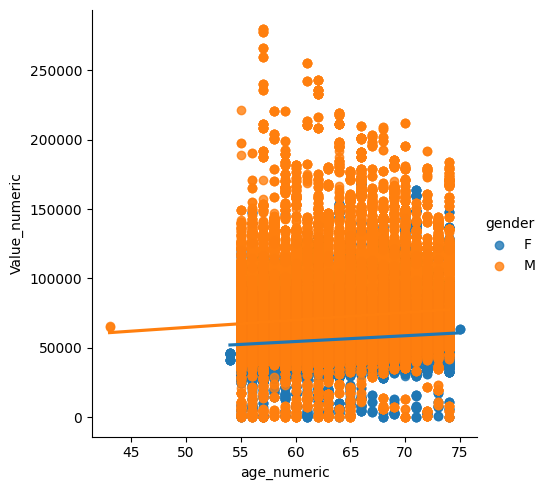

In [56]:
new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column
new_column = [np.float32(f) for f in df_plot['age'].values]
df_plot['age_numeric'] = new_column
sns.lmplot(x = "age_numeric", y = "Value_numeric",
           hue = "gender", data = df_plot)

Check for significance between M and F LA volumes.

In [63]:
from scipy.stats import mannwhitneyu

df_plot_males = df_plot[df_plot['gender'] == "M"]["Value_numeric"].values
df_plot_females = df_plot[df_plot['gender'] == "F"]["Value_numeric"].values
U1, p = mannwhitneyu(df_plot_males, df_plot_females)
print(U1)
print(p)


30074304448.5
0.0


P value is low, so there is a significant difference!

In [42]:
# ########## create bokeh plot with ohif urls

# output_notebook()

# # set the seed so jitter will be the same for each run
# np.random.seed(0)
# random.seed(0)

# #--- create df of the feature we want to plot ---#

# new_column = [np.float32(f) for f in df_plot['Value'].values]
# df_plot['Value_numeric'] = new_column

# colormap, colors = color_list_generator(df_plot, 'gender')
# df_plot['colors'] = colors
# # cats = df_plot.gender.unique()
# cats = list(colormap.keys())
# colors = list(colormap.values())

# # --- scatterplot of age on y axis vs feature on x axis for each gender --- #
# # --- also draw regression lines for each gender --- #

# hover = HoverTool(tooltips=[
#   (''.join(["(",'feature',")"]), "($y)")
# ])

# wZoom = WheelZoomTool()
# bZoom = BoxZoomTool()
# reset = ResetTool()
# tap = TapTool()
# pan = PanTool()

# p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan])

# # add scatter plot
# l1 = p.circle(x='age', y='Value_numeric', source=df_plot, size=3, alpha=1, color='colors')
# legend = Legend(items=[LegendItem(label=dict(field="gender"), renderers=[l1])])
# p.add_layout(legend, 'below')

# # add best fit line for each of the genders - create dataframe for plotting
# df_plot_with_line = pd.DataFrame()
# for g in range(0,len(colors)):
#   df_plot_line = df_plot[df_plot['gender']==cats[g]]
#   x = np.asarray(df_plot_line['age'].values).astype(np.float32)
#   y = np.asarray(df_plot_line['Value_numeric'].values)
#   par = np.polyfit(x, y, 1, full=True)
#   slope=par[0][0]
#   intercept=par[0][1]
#   y_predicted = [slope*i + intercept  for i in x]
#   # add to dataframe
#   df_plot_line['y_predicted'] = y_predicted
#   # df_plot_with_line = pd.concat([df_plot_with_line, df_plot_line])

#   l2 = p.line(x='age',y='y_predicted',source=df_plot_line, alpha=1, line_color=colors[g])



# # Add url
# url="@viewer_url"
# taptool = p.select(type=TapTool)
# taptool.callback = OpenURL(url=url)

# # Setup plot titles and such.
# p.title.text = 'Age vs ' + region + ' ' + feature
# p.xaxis.axis_label = 'Age'
# # p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = "white"
# p.grid.grid_line_width = 2
# # p.xaxis.major_label_text_font_size="0pt"
# # p.xaxis.major_label_orientation = np.pi/4
# p.yaxis.axis_label= region + ' ' + feature


# # show the plot
# show(p)


## 3.LA volume is significantly different between those with cardiovascular abnormalities and those without. The LA volume should be larger for those with cardiovascular abnormalities.


There should be a significant difference between CVD and no CVD in Volume.

The ones with CVD should be larger.

<Axes: xlabel='CV', ylabel='Value_numeric'>

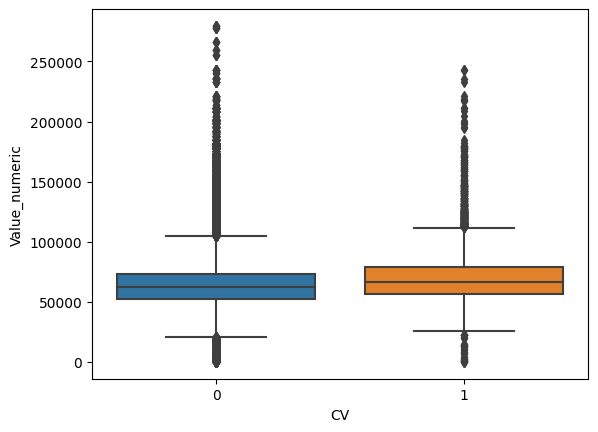

In [66]:
sns.boxplot(data=df_plot, x="CV", y="Value_numeric")


Visually, it seems that those with CV issues have larger volumes.

Now let's see if there is a significant difference:

In [64]:
from scipy.stats import mannwhitneyu

df_plot_males = df_plot[df_plot['CV'] == 1]["Value_numeric"].values
df_plot_females = df_plot[df_plot['CV'] == 0]["Value_numeric"].values
U1, p = mannwhitneyu(df_plot_males, df_plot_females)
print(U1)
print(p)

3015533982.0
2.0314810795289505e-212


There is a significant difference between the LA volumes of patients with significant cardiovascular abnormality, and those without!

# L3 vs age

Duan Y, Turner CH, Kim BT, Seeman E. Sexual dimorphism in vertebral fragility is more the result of gender differences in age‐related bone gain than bone loss. Journal of Bone and Mineral Research. 2001 Dec;16(12):2267-75.


1. The volume of vertebra L3 increases with age
2. The volume of vertebrae should be significantly different between males and females

Volume of L3 increases with age. F = open circles, M = filled circles. Significant differences between the two genders.

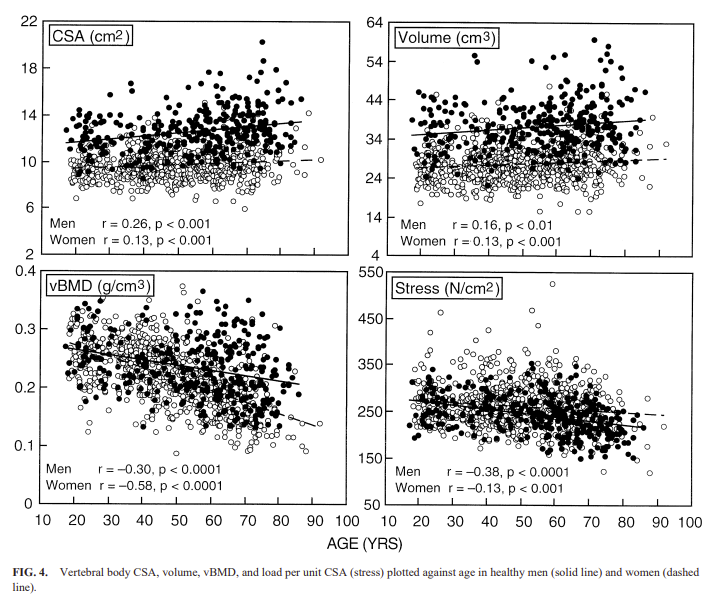

##1.The volume of vertebra L3 increases with age

First let's see how many patients have L3. We might have to pick a vertebrae above, as many might not have been scanned up to L3.

L1 vertebrae = 117138 series

L3 vertebrae = 12343 series

In [67]:
client = bigquery.Client(project=project_name)

query = f"""

SELECT
    DISTINCT(findingSite.CodeMeaning) AS findingSite_CodeMeaning,
    COUNT(DISTINCT(sourceSegmentedSeriesUID)) AS num_series
FROM
  `{table_id_126k}`
GROUP BY
  findingSite.CodeMeaning
ORDER BY
  findingSite.CodeMeaning;
"""

df = client.query(query).to_dataframe()

In [68]:
df

findingSite_CodeMeaning  num_series
0            Adrenal gland      124569
1                    Aorta      126050
2                    Brain         152
3              C1 vertebra          14
4              C2 vertebra          21
..                     ...         ...
71               Third rib      125780
72                 Trachea      125854
73             Twelfth rib      120289
74      Upper lobe of lung      126034
75         Urinary bladder          94

[76 rows x 2 columns]

Create plots in seaborn for particular region + feature comparing M and F.

In [69]:
def create_seaborn_plot_scatterplot_gender(region, feature, table_id):

  client = bigquery.Client(project=project_name)
  print(table_id)

  query = f"""

  SELECT
     DISTINCT(SOPInstanceUID),
     age,
     gender,
     Value
  FROM
    `{table_id}`
  WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df = client.query(query, job_config=job_config).to_dataframe()

  # Histograms of Volume values F vs M
  histogram = sns.histplot(data=df, x="Value", hue="gender")
  histogram.set(xlabel = feature, ylabel = "Count", title = feature + ' M vs F')

  return

Instead of L3 like the paper above, we do L1. As some patients may not have been scanned all the way to L3.

idc-external-025.terra.nlst-126k-measurements-clinical-acquisition


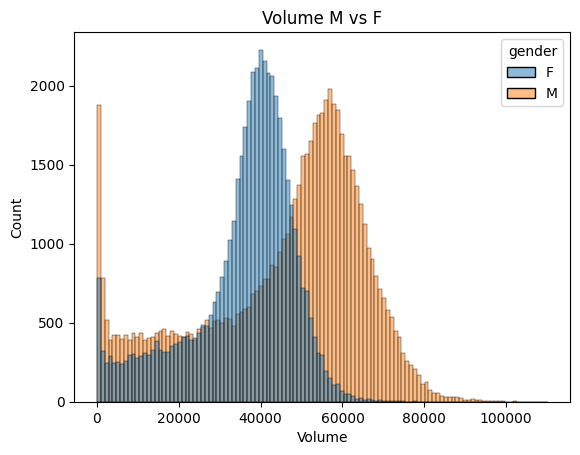

In [70]:
create_seaborn_plot_scatterplot_gender('L1 vertebra', 'Volume', table_id_126k)

In [82]:
def create_bokeh_plot_scatterplot_age(region, feature, table_id, viewer_url_string=None):

  client = bigquery.Client(project=project_name)
  print(table_id)

  # if name of table contains 10k, include the viewer_url
  if "10k" in table_id:
    query = f"""
      SELECT
        DISTINCT(SOPInstanceUID),
        StudyInstanceUID,
        PatientID,
        age,
        gender,
        Value,
        viewer_url
      FROM
        `{table_id}`
      WHERE
        findingSite.CodeMeaning = @region AND
        Quantity.CodeMeaning = @feature;
    """
    job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
    df_plot = client.query(query, job_config=job_config).to_dataframe()

  elif "126k" in table_id:
    query = f"""
      SELECT
        DISTINCT(SOPInstanceUID),
        StudyInstanceUID,
        PatientID,
        age,
        gender,
        Value
      FROM
        `{table_id}`
      WHERE
        findingSite.CodeMeaning = @region AND
        Quantity.CodeMeaning = @feature;
    """
    job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
    df_plot = client.query(query, job_config=job_config).to_dataframe()

    # add on the viewer_urls
    df_plot['viewer_url'] = [None] * len(df_plot)
    df_plot['viewer_url'] = [os.path.join("https://idc-tester-dk-2-server.web.app/viewer",
                                          f,
                                          "!secondGoogleServer=/projects/idc-external-025/locations/us-central1/datasets/total_segmentator_nlst_total_070823/dicomStores/126k-series")
                            for f in df_plot['StudyInstanceUID'].values]

  ########## create bokeh plot with ohif urls

  output_notebook()

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  #--- create df of the feature we want to plot ---#

  new_column = [np.float32(f) for f in df_plot['Value'].values]
  df_plot['Value_numeric'] = new_column

  colormap, colors = color_list_generator(df_plot, 'gender')
  df_plot['colors'] = colors
  # cats = df_plot.gender.unique()
  cats = list(colormap.keys())
  colors = list(colormap.values())

  # --- scatterplot of age on y axis vs feature on x axis for each gender --- #
  # --- also draw regression lines for each gender --- #

  hover = HoverTool(tooltips=[
    (''.join(["(",'feature',")"]), "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan])

  # add scatter plot
  l1 = p.circle(x='age', y='Value_numeric', source=df_plot, size=3, alpha=1, color='colors')
  legend = Legend(items=[LegendItem(label=dict(field="gender"), renderers=[l1])])
  p.add_layout(legend, 'below')

  # add best fit line for each of the genders - create dataframe for plotting
  df_plot_with_line = pd.DataFrame()
  for g in range(0,len(colors)):
    df_plot_line = df_plot[df_plot['gender']==cats[g]]
    x = np.asarray(df_plot_line['age'].values).astype(np.float32)
    y = np.asarray(df_plot_line['Value_numeric'].values)
    par = np.polyfit(x, y, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    y_predicted = [slope*i + intercept  for i in x]
    # add to dataframe
    df_plot_line['y_predicted'] = y_predicted
    # df_plot_with_line = pd.concat([df_plot_with_line, df_plot_line])

    l2 = p.line(x='age',y='y_predicted',source=df_plot_line, alpha=1, line_color=colors[g])



  # Add url
  url="@viewer_url"
  taptool = p.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  # Setup plot titles and such.
  p.title.text = 'Age vs ' + region + ' ' + feature
  p.xaxis.axis_label = 'Age'
  # p.xgrid.grid_line_color = None
  p.ygrid.grid_line_color = "white"
  p.grid.grid_line_width = 2
  # p.xaxis.major_label_text_font_size="0pt"
  # p.xaxis.major_label_orientation = np.pi/4
  p.yaxis.axis_label= region + ' ' + feature


  # show the plot
  show(p)



  return df_plot


This looks similar to the plot from the paper, similar trend.

In [79]:
df_plot = create_bokeh_plot_scatterplot_age("L1 vertebra", "Volume", table_id_10k)


idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa


In [83]:
# view for 126k - memory issues

# df_plot = create_bokeh_plot_scatterplot_age("L1 vertebra", "Volume", table_id_126k)


idc-external-025.terra.nlst-126k-measurements-clinical-acquisition
in 126k
created df for 126k


idc-external-025.terra.nlst-126k-measurements-clinical-acquisition


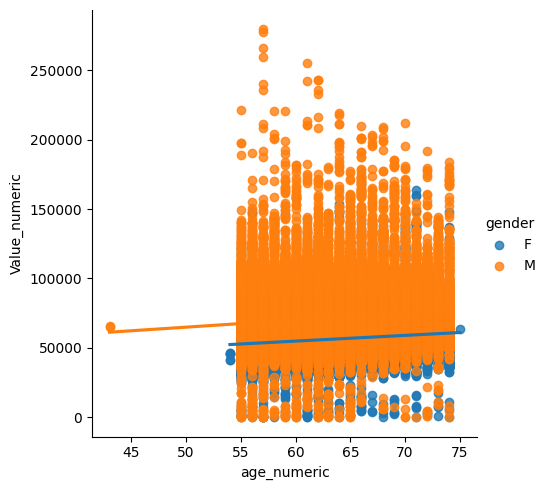

In [87]:
client = bigquery.Client(project=project_name)
print(table_id)

query = f"""
  SELECT
    DISTINCT(SOPInstanceUID),
    StudyInstanceUID,
    PatientID,
    age,
    gender,
    Value
  FROM
    `{table_id}`
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature;
"""
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("region", "STRING", region),
                                                      bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                      ])
df_plot = client.query(query, job_config=job_config).to_dataframe()

# add on the viewer_urls
df_plot['viewer_url'] = [None] * len(df_plot)
df_plot['viewer_url'] = [os.path.join("https://idc-tester-dk-2-server.web.app/viewer",
                                      f,
                                      "!secondGoogleServer=/projects/idc-external-025/locations/us-central1/datasets/total_segmentator_nlst_total_070823/dicomStores/126k-series")
                        for f in df_plot['StudyInstanceUID'].values]

new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column
new_column = [np.float32(f) for f in df_plot['age'].values]
df_plot['age_numeric'] = new_column
sns.lmplot(x = "age_numeric", y = "Value_numeric",
           hue = "gender", data = df_plot)

## 2.The volume of vertebrae should be significantly different between males and females

There should be a significant difference between M and F

In [80]:
from scipy.stats import mannwhitneyu

df_plot_males = df_plot[df_plot['gender'] == "M"]["Value_numeric"].values
df_plot_females = df_plot[df_plot['gender'] == "F"]["Value_numeric"].values
U1, p = mannwhitneyu(df_plot_males, df_plot_females)
print(U1)
print(p)


15497933.5
1.4060121899580003e-296


The p value is small, so there is a significant difference!

# Convolutional kernel analysis

In [ ]:
# SELECT
#   DISTINCT(ConvolutionKernel),
#   COUNT(DISTINCT(sourceSegmentedSeriesUID)) as num_series,
#   Manufacturer
# FROM
#   `idc-external-025.terra.nlst-126k-measurements-clinical-acquisition`
# GROUP BY
#   ConvolutionKernel,
#   Manufacturer
# ORDER BY
#   num_series DESC

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8010534/pdf/bjr.20200947.pdf

- For each of the 4 manufacturers, divide into sharp and smooth kernels
- For each study analyzed, we can keep the series that have at least 1 sharp and 1 smooth kernel, pick only 1 if more
- Pick a region - lung lobe, calculate ICC between sharp and smooth kernels across patients for a particular manufacturer
   - now divide across lung abnormality
- Bokeh plot - sharp distribution vs smooth distribution for a particular region, for a particular feature

In [ ]:
sharp_kernels = ['C', 'STANDARD', 'B30f']
smooth_kernels = ['D', 'LUNG', 'B50f']

In [ ]:
!pip install pandas-gbq

In [ ]:
import pandas_gbq

table_id_conv_explore = "idc-external-018.terra.conv-kernel-explore"

query = f"""

  SELECT
    *
  FROM
    `{table_id_conv_explore}`
"""
df = pandas_gbq.read_gbq(query, project_id=project_name)




Downloading:   0%|          |
Downloading:   1%|          |
Downloading:   2%|▏         |
Downloading:   2%|▏         |
Downloading:   3%|▎         |
Downloading:   4%|▍         |
Downloading:   5%|▍         |
Downloading:   5%|▌         |
Downloading:   6%|▌         |
Downloading:   7%|▋         |
Downloading:   8%|▊         |
Downloading:   8%|▊         |
Downloading:   9%|▉         |
Downloading:  10%|▉         |
Downloading:  11%|█         |
Downloading:  11%|█▏        |
Downloading:  12%|█▏        |
Downloading:  13%|█▎        |
Downloading:  14%|█▎        |
Downloading:  14%|█▍        |
Downloading:  15%|█▌        |
Downloading:  16%|█▌        |
Downloading:  17%|█▋        |
Downloading:  17%|█▋        |
Downloading:  18%|█▊        |
Downloading:  19%|█▉        |
Downloading:  20%|█▉        |
Downloading:  21%|██        |
Downloading:  21%|██▏       |
Downloading:  22%|██▏       |
Downloading:  23%|██▎       |
Downloading:  24%|██▎       |
Downloading:  24%|██▍       |
Downloadi

In [ ]:
set(df['ConvolutionKernel'].values)

{'LUNG', 'STANDARD'}

In [ ]:
def create_seaborn_plot_conv_kernel_comparison(df):

  histogram = sns.histplot(data=df_plot, x="Value", hue="ConvolutionKernel")
  histogram.set(xlabel = 'ConvolutionKernel', ylabel = "Count", title = 'Upper lobe of lung - for STANDARD vs LUNG kernel for GE')

  return df_plot

PatientID  sct_ab_desc  \
854        211094           65   
857        125185           51   
860        215965           61   
861        209091           52   
864        210774           59   
...           ...          ...   
2754648    127283           51   
2754722    218241           61   
2754732    203624           52   
2754744    110973           61   
2754810    205734           52   

                                          StudyInstanceUID  \
854      1.3.6.1.4.1.14519.5.2.1.7009.9004.206229030040...   
857      1.2.840.113654.2.55.21299401395548484301945816...   
860      1.3.6.1.4.1.14519.5.2.1.7009.9004.231518732805...   
861      1.3.6.1.4.1.14519.5.2.1.7009.9004.375065857556...   
864      1.3.6.1.4.1.14519.5.2.1.7009.9004.454512849862...   
...                                                    ...   
2754648  1.2.840.113654.2.55.59152775736725769426298161...   
2754722  1.3.6.1.4.1.14519.5.2.1.7009.9004.143136127834...   
2754732  1.3.6.1.4.1.14519.5.2.1.7009.9004.366785878817...   
2754744  1.2.840.113654.2.55.28059751824857450822829813...   
2754810  1.3.6.1.4.1.14519.5.2.1.7009.9004.309381908534...   

                                  sourceSegmentedSeriesUID ConvolutionKernel  \
854      1.3.6.1.4.1.14519.5.2.1.7009.9004.218041990763...              LUNG   
857      1.2.840.113654.2.55.24058836839189514235624608...          STANDARD   
860      1.3.6.1.4.1.14519.5.2.1.7009.9004.325481672660...          STANDARD   
861      1.3.6.1.4.1.14519.5.2.1.7009.9004.143833119429...          STANDARD   
864      1.3.6.1.4.1.14519.5.2.1.7009.9004.305479173140...              LUNG   
...                                                    ...               ...   
2754648  1.2.840.113654.2.55.71345862353472149869924317...          STANDARD   
2754722  1.3.6.1.4.1.14519.5.2.1.7009.9004.112055731896...          STANDARD   
2754732  1.3.6.1.4.1.14519.5.2.1.7009.9004.152858171706...              LUNG   
2754744  1.2.840.113654.2.55.70546138863841937676111628...              LUNG   
2754810  1.3.6.1.4.1.14519.5.2.1.7009.9004.110967217570...          STANDARD   

               Manufacturer  SliceThickness findingSite_CodeMeaning  \
854      GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
857      GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
860      GE MEDICAL SYSTEMS            1.25      Upper lobe of lung   
861      GE MEDICAL SYSTEMS            1.25      Upper lobe of lung   
864      GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
...                     ...             ...                     ...   
2754648  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2754722  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2754732  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2754744  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2754810  GE MEDICAL SYSTEMS            1.25      Upper lobe of lung   

        Quantity_CodeMeaning lateralityModifier_CodeMeaning           Value  \
854                     Mean                          Right  -765.069000000   
857                     Mean                          Right  -874.090000000   
860                     Mean                          Right  -797.512000000   
861                     Mean                          Right  -804.400000000   
864                     Mean                          Right  -861.396000000   
...                      ...                            ...             ...   
2754648                 Mean                          Right  -810.100000000   
2754722                 Mean                          Right  -717.448000000   
2754732                 Mean                          Right  -879.878000000   
2754744                 Mean                          Right  -752.977000000   
2754810                 Mean                          Right  -792.633000000   

                                                viewer_url  
854      https://idc-tester-dk

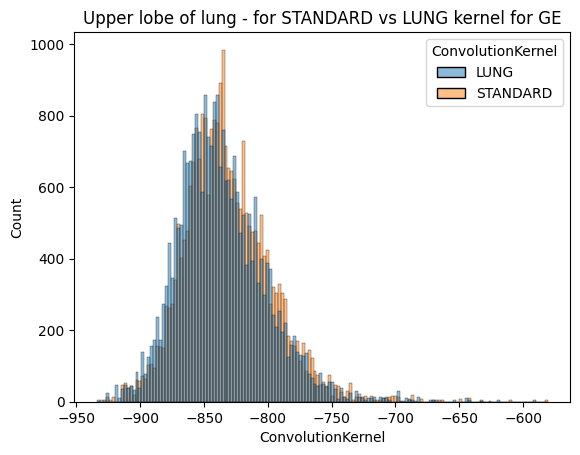

In [ ]:
df_plot = df[df['lateralityModifier_CodeMeaning']=='Right']
df_plot = df_plot[df_plot["Quantity_CodeMeaning"]=='Mean']
# Not much difference across both kernels -- shows that this feature (intensity feature) is stable
create_seaborn_plot_conv_kernel_comparison(df_plot)

PatientID  sct_ab_desc  \
857        125185           51   
868        210718           51   
1278       206342           51   
1467       203208           51   
1477       105877           51   
...           ...          ...   
2751388    212545           51   
2753451    132586           51   
2753456    112338           51   
2753457    216201           51   
2754648    127283           51   

                                          StudyInstanceUID  \
857      1.2.840.113654.2.55.21299401395548484301945816...   
868      1.3.6.1.4.1.14519.5.2.1.7009.9004.688095765277...   
1278     1.3.6.1.4.1.14519.5.2.1.7009.9004.219219944684...   
1467     1.3.6.1.4.1.14519.5.2.1.7009.9004.819089827715...   
1477     1.2.840.113654.2.55.82160247388944978639368041...   
...                                                    ...   
2751388  1.3.6.1.4.1.14519.5.2.1.7009.9004.287555168666...   
2753451  1.2.840.113654.2.55.28753153745313272068702733...   
2753456  1.2.840.113654.2.55.15476634988692760441769251...   
2753457  1.3.6.1.4.1.14519.5.2.1.7009.9004.112689011276...   
2754648  1.2.840.113654.2.55.59152775736725769426298161...   

                                  sourceSegmentedSeriesUID ConvolutionKernel  \
857      1.2.840.113654.2.55.24058836839189514235624608...          STANDARD   
868      1.3.6.1.4.1.14519.5.2.1.7009.9004.685068746964...          STANDARD   
1278     1.3.6.1.4.1.14519.5.2.1.7009.9004.238404721813...          STANDARD   
1467     1.3.6.1.4.1.14519.5.2.1.7009.9004.174967082192...              LUNG   
1477     1.2.840.113654.2.55.17110725970376934187491037...              LUNG   
...                                                    ...               ...   
2751388  1.3.6.1.4.1.14519.5.2.1.7009.9004.306343416883...          STANDARD   
2753451  1.2.840.113654.2.55.26545951845758076184192247...              LUNG   
2753456  1.2.840.113654.2.55.33560874897266501861809508...              LUNG   
2753457  1.3.6.1.4.1.14519.5.2.1.7009.9004.100174268619...              LUNG   
2754648  1.2.840.113654.2.55.71345862353472149869924317...          STANDARD   

               Manufacturer  SliceThickness findingSite_CodeMeaning  \
857      GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
868      GE MEDICAL SYSTEMS            1.25      Upper lobe of lung   
1278     GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
1467     GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
1477     GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
...                     ...             ...                     ...   
2751388  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2753451  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2753456  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2753457  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   
2754648  GE MEDICAL SYSTEMS            2.50      Upper lobe of lung   

        Quantity_CodeMeaning lateralityModifier_CodeMeaning           Value  \
857                     Mean                          Right  -874.090000000   
868                     Mean                          Right  -824.720000000   
1278                    Mean                          Right  -824.739000000   
1467                    Mean                          Right  -827.036000000   
1477                    Mean                          Right  -807.796000000   
...                      ...                            ...             ...   
2751388                 Mean                          Right  -828.350000000   
2753451                 Mean                          Right  -879.790000000   
2753456                 Mean                          Right  -867.168000000   
2753457                 Mean                          Right  -776.870000000   
2754648                 Mean                          Right  -810.100000000   

                                                viewer_url  
857      https://idc-tester-dk

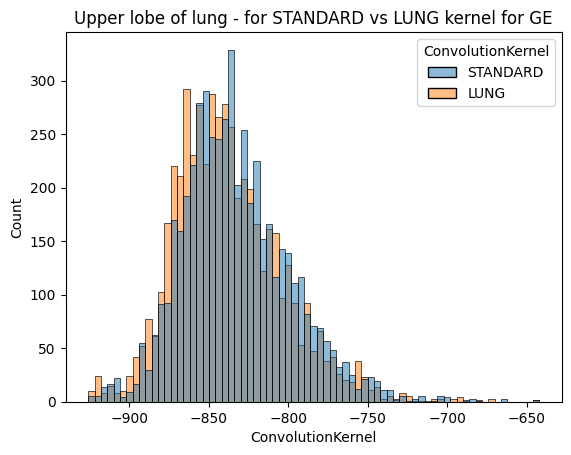

In [ ]:
# What about across abnormalities?

df_plot = df[df['lateralityModifier_CodeMeaning']=='Right']
df_plot = df_plot[df_plot["Quantity_CodeMeaning"]=='Mean']
df_plot = df_plot[df_plot["sct_ab_desc"]==51]
# Not much difference across both kernels --
create_seaborn_plot_conv_kernel_comparison(df_plot)

# Old

In [ ]:
import pandas_gbq

table_id_conv_explore = "idc-external-018.terra.conv-kernel-explore-ge"

query = f"""

  SELECT
    *
  FROM
    `{table_id_conv_explore}`
"""
df = pandas_gbq.read_gbq(query, project_id=project_name)




Downloading:   0%|          |


Downloading:   1%|▏         |

Downloading:   3%|▎         |

Downloading:   3%|▎         |

Downloading:   4%|▍         |

Downloading:   6%|▌         |

Downloading:   6%|▌         |

Downloading:   7%|▋         |

Downloading:   9%|▊         |

Downloading:   9%|▊         |

Downloading:  10%|█         |

Downloading:  12%|█▏        |

Downloading:  12%|█▏        |

Downloading:  13%|█▎        |

Downloading:  14%|█▍        |

Downloading:  14%|█▍        |

Downloading:  16%|█▌        |

Downloading:  16%|█▌        |

Downloading:  17%|█▋        |

Downloading:  17%|█▋        |

Downloading:  19%|█▉        |

Downloading:  20%|██        |

Downloading:  22%|██▏       |

Downloading:  22%|██▏       |

Downloading:  23%|██▎       |

Downloading:  25%|██▍       |

Downloading:  25%|██▍       |

Downloading:  26%|██▌       |

Downloading:  27%|██▋       |

Downloading:  29%|██▉       |

Downloading:  29%|██▉       |

Downloading:  30%|███       |

Downl

In [ ]:
df

StudyInstanceUID ConvolutionKernel  \
0        1.3.6.1.4.1.14519.5.2.1.7009.9004.250097210619...              LUNG   
1        1.3.6.1.4.1.14519.5.2.1.7009.9004.250015819566...              LUNG   
2        1.3.6.1.4.1.14519.5.2.1.7009.9004.262092603610...              LUNG   
3        1.3.6.1.4.1.14519.5.2.1.7009.9004.329590884810...              LUNG   
4        1.3.6.1.4.1.14519.5.2.1.7009.9004.281087575394...              LUNG   
...                                                    ...               ...   
8470218  1.2.840.113654.2.55.23449438136617720954706783...              LUNG   
8470219  1.3.6.1.4.1.14519.5.2.1.7009.9004.244640100743...              LUNG   
8470220  1.2.840.113654.2.55.92929049233120995971550317...              LUNG   
8470221  1.3.6.1.4.1.14519.5.2.1.7009.9004.280636501455...              LUNG   
8470222  1.2.840.113654.2.55.33441132555032240331311668...              LUNG   

                  Value  
0        -863.485000000  
1        -880.959000000  
2        -788.779000000  
3        -821.337000000  
4        -845.742000000  
...                 ...  
8470218  -802.674000000  
8470219  -857.946000000  
8470220  -858.158000000  
8470221  -858.100000000  
8470222  -872.222000000  

[8470223 rows x 3 columns]

In [ ]:
set(df['ConvolutionKernel'].values)

{'LUNG'}

In [ ]:
def create_seaborn_plot_conv_kernel_comparison(df):

  histogram = sns.histplot(data=df_plot, x="Value", hue="ConvolutionKernel")
  histogram.set(xlabel = 'ConvolutionKernel', ylabel = "Count", title = 'Upper lobe of lung - left for STANDARD vs LUNG kernel for GE - Mean intensity value')

  return df_plot

In [ ]:

create_seaborn_plot_conv_kernel_comparison(df)

ValueError: ignored